# ECG anormaly detection using LSTM-AE network.
Last update: March 9, 2023\
Author: Chang-Gil, Jeong

Preprocessing from original database.\
filtering, segmentation

In [1]:
fsTarget = 120
segTime = 3
segLen = fsTarget*segTime

In [2]:
import Preprocessing
Preprocessing.ecgProcessing("mitdb/", segTime, fsTarget)


100%|██████████| 48/48 [00:09<00:00,  4.99it/s]


Normal:(34865, 360)
fore Normal:(34865, 360)
Arrhythmia:(1657, 360)
Abnormal:(21126, 360)


In [3]:
import numpy as np 
import tensorflow as tf

Load dataset

In [4]:
N = np.load('N.npy')
Nf = np.load('Nf.npy')
A = np.load('A.npy')

idN = np.load('idN.npy')
idA = np.load('idA.npy')

# shuffling
rdIdx = np.random.permutation(len(N))
N = N.reshape((-1,segLen,1))
Nf = Nf.reshape((-1,segLen,1))
A = A.reshape((-1,segLen,1))

N = N[rdIdx]
Nf = Nf[rdIdx]
N = N[rdIdx]

print(N.shape,Nf.shape,A.shape)

(34865, 360, 1) (34865, 360, 1) (1657, 360, 1)


Split Train and Test

In [6]:
splitIdx = -1*len(A)
xTrain = N[:splitIdx]
fTrain = Nf[:splitIdx]

iTrain = N[:splitIdx]

xTest = np.concatenate((N[splitIdx:],A))
iTest = np.concatenate((idN[splitIdx:],idA))

Define LSTM-AE network
- to use cuDNN accelation in LSTM layer, activation function must be 'tanh'

In [7]:
act = 'tanh'
#act = 'leaky_relu'
netInput = tf.keras.layers.Input(shape=(segLen,1))

encoder_1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(180,activation=act, return_sequences=True))(netInput)
encoder_2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(90,activation=act, return_sequences=False))(encoder_1)
rpt = tf.keras.layers.RepeatVector(segLen)(encoder_2)

decoder1_1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(90,activation=act, return_sequences=True))(rpt)
decoder1_2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(180,activation=act, return_sequences=True))(decoder1_1)
reconstruct = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1,activation='leaky_relu'),name="recons")(decoder1_2)

decoder2_1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(90,activation=act, return_sequences=True))(rpt)
decoder2_2 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(180,activation=act, return_sequences=True))(decoder2_1)
forecast = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1,activation='leaky_relu'),name="fore")(decoder2_2)

lstmAE = tf.keras.Model(inputs=netInput,outputs=[reconstruct,forecast])
lstmAE.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
            loss='mse') # mean squared error
lstmAE.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 360, 1)]     0           []                               
                                                                                                  
 bidirectional (Bidirectional)  (None, 360, 360)     262080      ['input_1[0][0]']                
                                                                                                  
 bidirectional_1 (Bidirectional  (None, 180)         324720      ['bidirectional[0][0]']          
 )                                                                                                
                                                                                                  
 repeat_vector (RepeatVector)   (None, 360, 180)     0           ['bidirectional_1[0][0]']    

use live plot tool \
https://github.com/stared/livelossplot \
pip install livelossplot \
not installed now

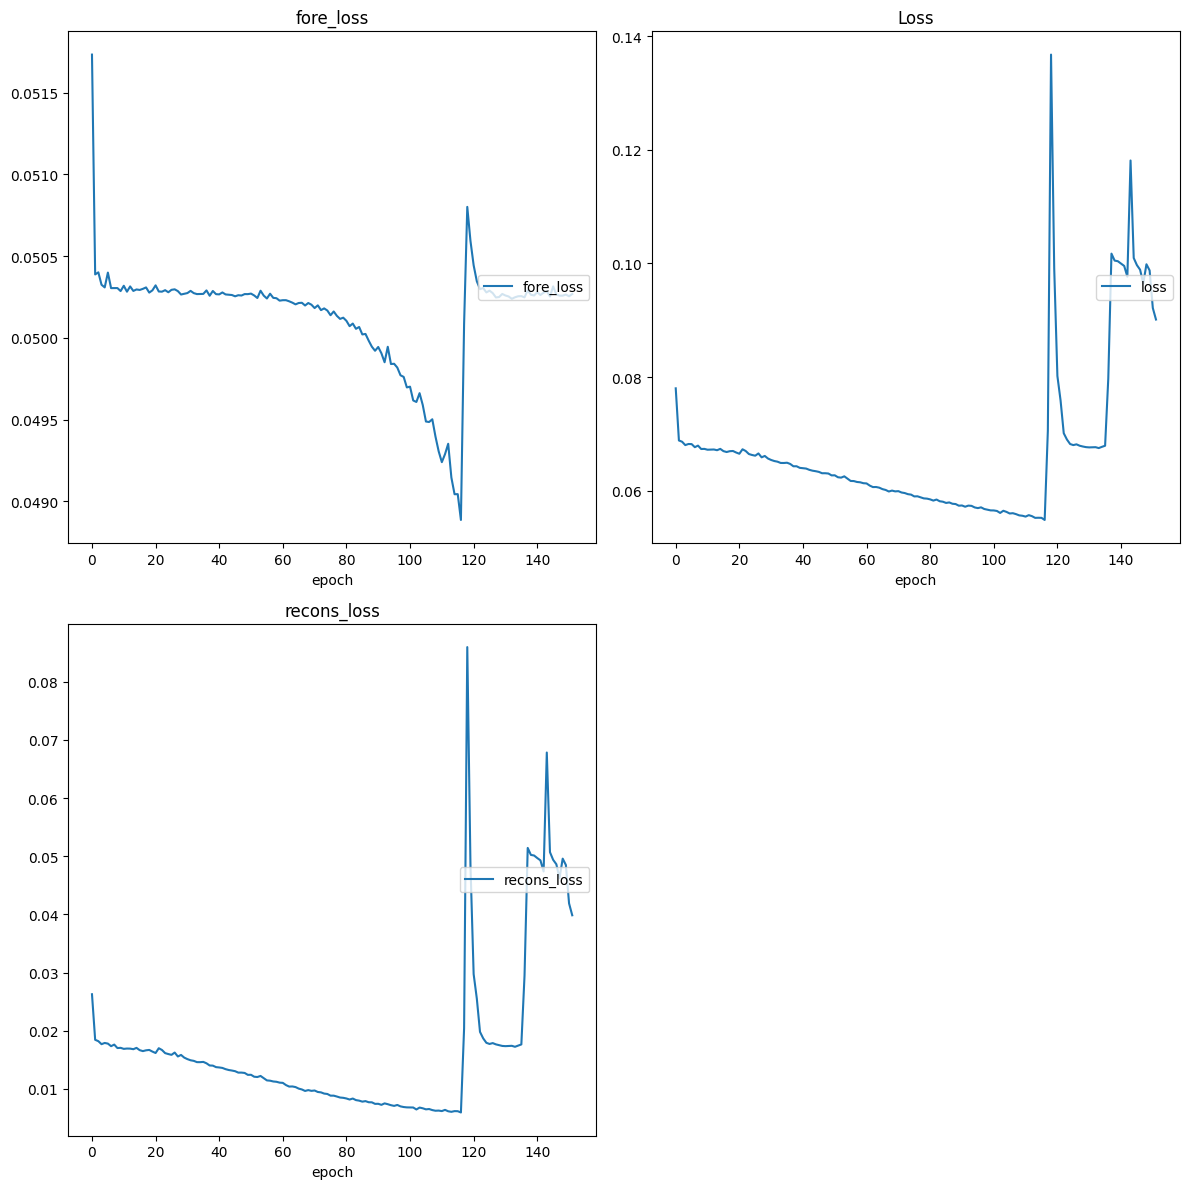

fore_loss
	fore_loss        	 (min:    0.049, max:    0.052, cur:    0.050)
Loss
	loss             	 (min:    0.055, max:    0.137, cur:    0.090)
recons_loss
	recons_loss      	 (min:    0.006, max:    0.086, cur:    0.040)
33/33 [==============================] - 22s 674ms/step - loss: 0.0901 - recons_loss: 0.0399 - fore_loss: 0.0503


In [8]:
cb_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=35, restore_best_weights=True)

from livelossplot import PlotLossesKeras
cb_plot = PlotLossesKeras()

lstmAE.fit(xTrain, [xTrain,fTrain], epochs=500, batch_size=1024, callbacks=[cb_stop,cb_plot])

Test set

In [9]:
xHat, _ = np.array(lstmAE.predict(xTest))

104/104 [==============================] - 15s 128ms/step


In [10]:
lstmAE.save('lstmAE_v1')

INFO:tensorflow:Assets written to: lstmAE_v1\assets


INFO:tensorflow:Assets written to: lstmAE_v1\assets


In [11]:
selfScore = np.sqrt(np.power(xTest-xHat,2)).reshape(-1,segLen)

selfScore = np.mean(selfScore,1)

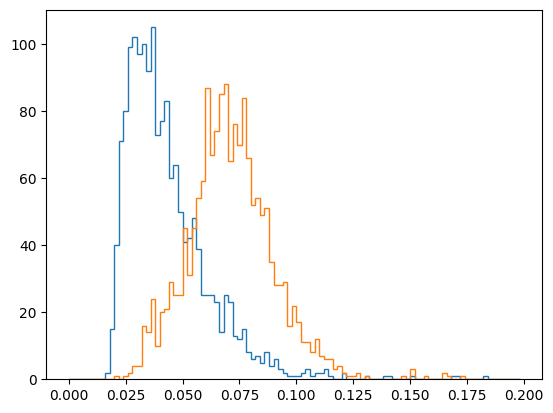

In [12]:
import matplotlib.pyplot as plt 

bins = np.arange(0, 0.2, 0.002)

plt.hist(selfScore[:splitIdx],bins, facecolor='blue', histtype='step');
plt.hist(selfScore[splitIdx:],bins, facecolor='red', histtype='step');
plt.show()

### Getting dizzy segments

In [58]:
dizzySample = []
dizzyScore = []
dizzyLabel = []
dizzyId = []
for idx,s,sig,id in zip(range(len(selfScore)),selfScore,xTest,iTest):
    if s <= 0.04 and idx >= len(A):
        dizzyScore.append(s)
        dizzySample.append(sig)
        dizzyLabel.append(False)
        dizzyId.append(id)
    elif s > 0.04 and idx < len(A):
        dizzyScore.append(s)
        dizzySample.append(sig)
        dizzyLabel.append(True)
        dizzyId.append(id)
        
dizzyScore = np.array(dizzyScore)
dizzySample = np.array(dizzySample).reshape(-1,360)
dizzyLabel = np.array(dizzyLabel)
dizzyId = np.array(dizzyId)
print(np.array(dizzyId).shape)

(857,)


### Augmentation Options:
1. Roll signal(0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9) - 9 options
2. change scale each rolled segment \
 2.2- under segment - 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0
3. flip wave form
4. reverse

In [41]:
import tqdm
augImage = []

for dizzySignal in tqdm.tqdm(dizzySample):
    rollRd = np.random.randint(1,segLen,(segLen-1))
    augImage.append(dizzySignal) # First line as original
    for rollPoint in rollRd:
        rdScale = (1.2-0.8)*np.random.random() + 0.8
        rdScale *= 1 if np.random.randint(0,1,dtype=bool) else -1
        sig = list(map(lambda x: x*rdScale, dizzySignal[rollPoint:]+dizzySignal[:rollPoint]))
        augImage.append(sig)
AuSigImage = np.array(augImage).reshape(-1,360,360)
print(AuSigImage.shape)

  0%|          | 0/857 [00:00<?, ?it/s]

100%|██████████| 857/857 [00:09<00:00, 93.68it/s] 


(857, 360, 360)


In [1]:
Nimage = AuSigImage[dizzyLabel]
Aimage = AuSigImage[~dizzyLabel]

Nscore = np.array(dizzyScore)[dizzyLabel]
Ascore = np.array(dizzyScore)[~dizzyLabel]

Nid = np.array(dizzyId)[dizzyLabel]
Aid = np.array(dizzyId)[~dizzyLabel]

Nsample = np.array(dizzySample)[dizzyLabel]
Asample = np.array(dizzySample)[~dizzyLabel]

print()


NameError: name 'AuSigImage' is not defined

In [49]:
i = 0

for _ in range(5):   
    while Aid[i] not in Nid and i < len(Aid):
        i += 1
    j = 0
    while Nid[j] != Aid[i] and j < len(Nid):
        j += 1

    plt.figure(figsize=(12,12))
    plt.subplot(2,2,1)
    plt.imshow(Nimage[j])
    plt.title('Normal | score {}'.format(Nscore[j]))
    plt.subplot(2,2,2)
    plt.plot(Asample[j])
    plt.subplot(2,2,3)
    plt.imshow(Aimage[i])
    plt.title('Abnormal | score {}'.format(Ascore[i]))
    plt.subplot(2,2,4)
    plt.plot(Asample[i])
    plt.show()

IndexError: index 0 is out of bounds for axis 0 with size 0